In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import os
import re
import networkx as nx
from scipy.spatial.distance import euclidean
import math
from Proteins_AA import nodes, edges, ollivier_ricci_node, ollivier_ricci_edge, node_connect_path, path_pd_all_w, path_sum_mean, edge_node_vec_torsion, mirror_point, mirror_check_chiral
import igraph as ig
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
_base = math.e
_exp_power = 2
_alpha = 0.5
_nbr_topk = 1000
EPSILON = 1e-7

In [3]:
def pos_G(g_ig, xyz_l, elcolors=False):
    n = g_ig.vcount()
    edge_max = g_ig.maxdegree()
    degrees = np.array(g_ig.degree())

    if elcolors == True:
        eldict = {'N': 'blue',
                  'O': 'red',
                  'C': 'black',
                  'H': 'white',
                  'S': 'yellow'}
        elements = [_[0] for _ in xyz_l.index]
        colors = [eldict[_] for _ in elements]

    else:
        colors = plt.cm.plasma(degrees / edge_max)

    coords_ = np.array(xyz_l[['x', 'y', 'z']])
    lines = np.append(np.expand_dims(coords_[edge_l[:, 0]], axis=1), np.expand_dims(coords_[edge_l[:, 1]], axis=1),
                      axis=1)

    with plt.style.context(('ggplot')):
        fig = plt.figure(figsize=(10, 7))
        # ax = Axes3D(fig)
        ax = plt.figure().add_subplot(projection='3d')

        lc = Line3DCollection(lines, colors='black', alpha=0.5)
        ax.add_collection3d(lc)
        ax.scatter(xyz_l['x'], xyz_l['y'], xyz_l['z'], c=colors, s=10 + 10 * degrees, edgecolors='k', alpha=0.7)

        ax.view_init(0, 0)
        ax.set_axis_off()
        ax.set_xlim([min(xyz_l['x']), max(xyz_l['x'])])
        ax.set_ylim([min(xyz_l['y']), max(xyz_l['y'])])
        ax.set_zlim([min(xyz_l['z']), max(xyz_l['z'])])

    plt.show()


def get_cif(AA_filename, center=True):
    pattern = r'[0-9]'
    AA_elements = []
    AA_coords = []

    AA_filepath = os.path.join(AA_dir, AA_filename)

    with open(AA_filepath, "r") as f:
        for i, line in enumerate(f):
            line_ = line.strip().split()
            try:
                if len(line_) == 21:
                    # print(line_)
                    ele, x, y, z = line_[1], line_[15], line_[16], line_[17]
                    point = (float(x), float(y), float(z))
                    AA_elements.append(re.sub(pattern, '', ele))
                    AA_coords.append(point)
            except:
                continue
                # print(line.strip().split())
    AA_coords = np.array(AA_coords)
    if center == True:
        AA_coords = AA_coords - AA_coords[np.array(AA_elements) == 'CA']
    AA_df = pd.DataFrame(columns=['ATOM', 'x', 'y', 'z'])
    AA_df[['x', 'y', 'z']] = AA_coords
    AA_df.index = AA_elements
    ele1 = np.array([np.array(AA_df.index)[ii][0] for ii in range(len(AA_df.index))])
    AA_df_noh = AA_df.loc[ele1 != 'H']

    c_alpha = AA_df_noh[AA_df_noh.index == 'CA'][['x', 'y', 'z']].to_numpy()
    amine = AA_df_noh[AA_df_noh.index == 'N'][['x', 'y', 'z']].to_numpy()
    cooh_mean = np.mean(AA_df_noh[(AA_df_noh.index == 'C') | (AA_df_noh.index == 'O') | (AA_df_noh.index == 'OXT')][
                            ['x', 'y', 'z']].to_numpy(), axis=0).reshape(1, -1)
    r_mean = np.mean(AA_df_noh[(AA_df_noh.index != 'C') & (AA_df_noh.index != 'CA') & (AA_df_noh.index != 'N') & (
                AA_df_noh.index != 'O') & (AA_df_noh.index != 'OXT')][['x', 'y', 'z']].to_numpy(), axis=0).reshape(1,
                                                                                                                   -1)

    AA_coarse = pd.DataFrame(columns=['ATOM', 'x', 'y', 'z'])
    AA_coarse['ATOM'] = [0, 0, 0, 0]
    AA_coarse[['x', 'y', 'z']] = np.concatenate([c_alpha, amine, cooh_mean, r_mean], axis=0)
    AA_coarse.index = ['CA', 'N', 'COOH', 'R']
    AA_coarse.dropna()

    return AA_df_noh, AA_coarse.dropna(), ele1

In [4]:
def GT_chirality(AA_filename):
    _, xyz_l, ele1 = get_cif(AA_filename)

    thre = 1
    al = 7

    node_l = nodes(xyz_l)
    node_len = len(xyz_l)
    edge_l, weights = edges(xyz_l, node_l, al, thre)

    g_ig = ig.Graph(n=node_len, edges=edge_l)
    g_ig.es['weight'] = np.ones(len(edge_l))
    norm_w = weights / np.linalg.norm(weights)
    g_w = copy.deepcopy(g_ig)
    g_w.es['weight'] = norm_w
    Gw_l = g_w.to_networkx()
    nx.set_edge_attributes(Gw_l, {(e[0], e[1]): g_w.es['weight'][i] for i, e in enumerate(g_w.get_edgelist())},
                           'weight')

    orn_w_l = ollivier_ricci_node(Gw_l, 0.5)
    ore_w_l = ollivier_ricci_edge(Gw_l, 0.5)


    path_l = []

    for ii in range(len(edge_l)):
        _, _, path = node_connect_path(g_ig, edge_l[ii])
        path_l.append(path)

    path_l_w = copy.deepcopy(path_l)

    path_w_l = path_pd_all_w(Gw_l, g_w, path_l_w)
    print('path l done')

    path_l_w_sum_mean = path_sum_mean(edge_l, path_w_l)

    points0 = xyz_l[xyz_l.index == 'CA'][['x', 'y', 'z']].to_numpy()
    points1 = xyz_l[xyz_l.index == 'COOH'][['x', 'y', 'z']].to_numpy()
    points2 = xyz_l[xyz_l.index == 'N'][['x', 'y', 'z']].to_numpy()

    v1 = points1 - points0
    v2 = points2 - points0

    cp = np.squeeze(np.cross(v1, v2))

    a, b, c = cp
    d = np.dot(cp, points0[0])

    scale = np.max(np.abs([a, b, c, d]))

    a = a / scale
    b = b / scale
    c = c / scale
    d = d / scale

    xyz, G, edge_path, orn, ore, a, b, c, d = xyz_l, Gw_l, path_l_w_sum_mean, orn_w_l, ore_w_l, a, b, c, d
    edge_vec, node_vec, center_node, center, pos = edge_node_vec_torsion(xyz, G, edge_path)
    node_pair = mirror_check_chiral(xyz, G, orn, ore, a, b, c, d)
    
    plane_sign = pd.DataFrame(np.zeros((len(node_pair), 4)), columns=['n0', 'n0_sign',
                                                                      'n1', 'n1_sign', ])

    plane_sign['n0'] = node_pair[:, 0]
    plane_sign['n1'] = node_pair[:, 1]

    for ii in range(len(plane_sign)):
        n0 = plane_sign['n0'].iloc[ii].astype('int32')

        n0_x = node_vec['direction'].iloc[n0][0]
        n0_y = node_vec['direction'].iloc[n0][1]
        n0_z = node_vec['direction'].iloc[n0][2]

        value = a * n0_x + b * n0_y + c * n0_z - d
        if np.isclose(value, 0, atol=1e-03):
            value = 0
        plane_sign['n0_sign'].iloc[ii] = np.sign(value)

    for ii in range(len(plane_sign)):
        if np.isnan(plane_sign['n1'].iloc[ii]) == False:
            n1 = plane_sign['n1'].iloc[ii].astype('int32')
            #         print(n1)

            n1_x = node_vec['direction'].iloc[n1][0]
            n1_y = node_vec['direction'].iloc[n1][1]
            n1_z = node_vec['direction'].iloc[n1][2]

            value = a * n0_x + b * n0_y + c * n0_z - d
            if np.isclose(value, 0, atol=1e-03):
                value = 0
        plane_sign['n1_sign'].iloc[ii] = np.sign(value)

    plus_diff = []
    plus_val_diff = []

    p_ind = np.where(plane_sign['n0_sign'] > 0)[0]

    for ii in range(len(p_ind)):
        if np.isnan(plane_sign['n1'].iloc[p_ind[ii]]) == True:

            n0 = node_pair[p_ind[ii]][0].astype('int32')
            #         print(n0)
            m_point = mirror_point(a, b, c, -d, node_vec['direction'].iloc[n0][0],
                                   node_vec['direction'].iloc[n0][1],
                                   node_vec['direction'].iloc[n0][2])
            m_point_arr = np.asarray(m_point)
            diff = euclidean(m_point_arr, [0, 0, 0])
            plus_diff.append(diff)

            val = node_vec['op_mean'].iloc[n0]
            plus_val_diff.append(np.abs(val))

        else:
            n0 = node_pair[p_ind[ii]][0].astype('int32')
            n1 = node_pair[p_ind[ii]][1].astype('int32')
            m_point = mirror_point(a, b, c, -d, node_vec['direction'].iloc[n0][0],
                                   node_vec['direction'].iloc[n0][1],
                                   node_vec['direction'].iloc[n0][2])
            m_point_arr = np.asarray(m_point)
            diff = euclidean(node_vec['direction'].iloc[n1], m_point_arr)
            plus_diff.append(diff)

            val0 = node_vec['op_mean'].iloc[n0]
            val1 = node_vec['op_mean'].iloc[n1]

            plus_val_diff.append(np.abs(val0 - val1))

    minus_diff = []
    minus_val_diff = []

    m_ind = np.where(plane_sign['n0_sign'] < 0)[0]

    for ii in range(len(m_ind)):
        if np.isnan(plane_sign['n1'].iloc[m_ind[ii]]) == True:

            n0 = node_pair[m_ind[ii]][0].astype('int32')
            #         print(n0)
            m_point = mirror_point(a, b, c, -d, node_vec['direction'].iloc[n0][0],
                                   node_vec['direction'].iloc[n0][1],
                                   node_vec['direction'].iloc[n0][2])
            m_point_arr = np.asarray(m_point)
            diff = euclidean(m_point_arr, [0, 0, 0])
            minus_diff.append(diff)

            val = node_vec['op_mean'].iloc[n0]
            minus_val_diff.append(np.abs(val))

        else:
            n0 = node_pair[m_ind[ii]][0].astype('int32')
            n1 = node_pair[m_ind[ii]][1].astype('int32')
            m_point = mirror_point(a, b, c, -d, node_vec['direction'].iloc[n0][0],
                                   node_vec['direction'].iloc[n0][1],
                                   node_vec['direction'].iloc[n0][2])
            m_point_arr = np.asarray(m_point)
            diff = euclidean(node_vec['direction'].iloc[n1], m_point_arr)
            minus_diff.append(diff)

            val0 = node_vec['op_mean'].iloc[n0]
            val1 = node_vec['op_mean'].iloc[n1]

            minus_val_diff.append(np.abs(val0 - val1))

    if len(plus_diff) == 0:
        plus = 0
    else:
        plus = np.sum(np.asarray(plus_diff) * np.asarray(plus_val_diff)) / len(plus_diff)
    if len(minus_diff) == 0:
        minus = 0
    else:
        minus = np.sum(np.asarray(minus_diff) * np.asarray(minus_val_diff) / len(minus_diff))

    chirality = plus - minus

    return chirality

In [5]:
AA_dir = os.path.join(os.getcwd(), 'AA_CIF')
AA_name = []
chirality = []
for AA_filename in os.listdir(AA_dir):
    AA_name.append((AA_filename[0:3]))
    chirality.append(GT_chirality(AA_filename))

path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done
path l done


In [6]:
GTC = np.append(np.array(AA_name).reshape(-1, 1), np.array(chirality).reshape(-1, 1), axis=1)
GTC

array([['TRP', '-1.3583691144898724'],
       ['ASP', '-1.14880236045762'],
       ['THR', '-0.9272450980663095'],
       ['GLN', '-1.2061504571221615'],
       ['LYS', '-1.2869899285674307'],
       ['HIS', '-0.9024484940161404'],
       ['PHE', '-1.346221189115667'],
       ['MET', '-1.2515395640586038'],
       ['GLY', '0.0'],
       ['SER', '-0.9684610942810249'],
       ['VAL', '-0.9283009650899866'],
       ['CYS', '-1.0206192428496537'],
       ['GLU', '-1.2025968669861897'],
       ['PRO', '-1.0522268604364742'],
       ['TYR', '-1.3999541580941142'],
       ['ALA', '-0.7769359706024688'],
       ['ILE', '-1.01756052634917'],
       ['ARG', '-1.1416984907005876'],
       ['ASN', '-1.1497841811631433'],
       ['LEU', '-1.139581513213952']], dtype='<U32')

In [7]:
AA_filename = 'CYS.cif'

In [8]:
_, xyz_l, ele1 = get_cif(AA_filename)

thre = 1
al = 7

node_l = nodes(xyz_l)
node_len = len(xyz_l)
edge_l, weights = edges(xyz_l, node_l, al, thre)

g_ig = ig.Graph(n=node_len, edges=edge_l)
g_ig.es['weight'] = np.ones(len(edge_l))
norm_w = weights / np.linalg.norm(weights)
g_w = copy.deepcopy(g_ig)
g_w.es['weight'] = norm_w
Gw_l = g_w.to_networkx()
nx.set_edge_attributes(Gw_l, {(e[0], e[1]): g_w.es['weight'][i] for i, e in enumerate(g_w.get_edgelist())}, 'weight')

orn_w_l = ollivier_ricci_node(Gw_l, 0.5)
ore_w_l = ollivier_ricci_edge(Gw_l, 0.5)

<Figure size 1000x700 with 0 Axes>

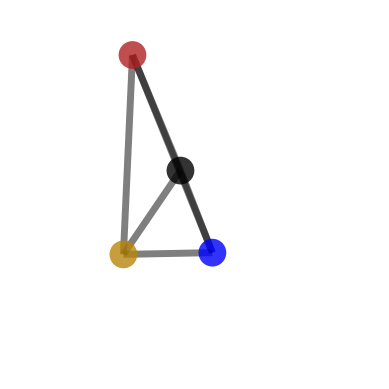

In [9]:
plt.close()

n = g_ig.vcount()
edge_max = g_ig.maxdegree()
degrees = np.array(g_ig.degree())

colors_ = ['black', 'blue', 'firebrick', 'darkgoldenrod']
coords_ = np.array(xyz_l[['x','y','z']])
lines = np.append(np.expand_dims(coords_[edge_l[:,0]], axis=1), np.expand_dims(coords_[edge_l[:,1]], axis=1), axis=1)

fig = plt.figure(figsize=(10,7))
ax = plt.figure().add_subplot(projection='3d')

lc = Line3DCollection(lines, linewidths=5, colors = 'black', alpha=0.5)
ax.add_collection3d(lc)
ax.scatter(xyz_l['x'], xyz_l['y'], xyz_l['z'], c=colors_, s=100+100*degrees, edgecolors='none', alpha=0.8)

ax.view_init(40,-16)
ax.set_axis_off()
ax.set_xlim([min(xyz_l['x']),max(xyz_l['x'])])
ax.set_ylim([min(xyz_l['y']),max(xyz_l['y'])])
ax.set_zlim([min(xyz_l['z']),max(xyz_l['z'])])
    
plt.axis('scaled')
plt.savefig('CYS_graph.png')
plt.show()

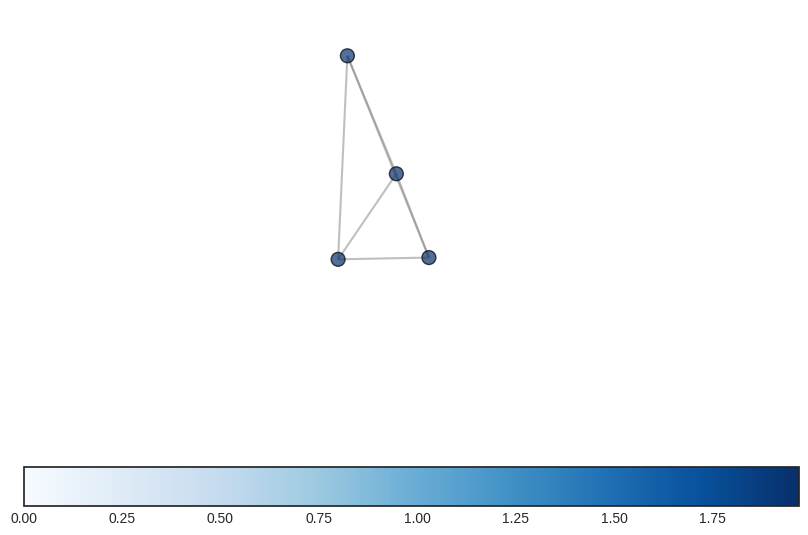

In [11]:
G = Gw_l
ORC, theta, phi = orn_w_l, 40,-16

orc = np.asarray(ORC)

norm = colors.Normalize(vmin=0, vmax=np.max(abs(orc)), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)

co = mapper.to_rgba(orc)  

with plt.style.context(('seaborn-v0_8-white')):
    ax = plt.figure(figsize=(10,7)).add_subplot(projection='3d')
    
    lines = np.append(np.expand_dims(np.array(xyz_l[['x', 'y', 'z']])[np.array(G.edges)[:,0]], axis=1),
                      np.expand_dims(np.array(xyz_l[['x', 'y', 'z']])[np.array(G.edges)[:,1]], axis=1), axis=1)
    
    lc = Line3DCollection(lines, color='gray', alpha=0.5)
    ax.add_collection3d(lc)
    
    ax.scatter(xyz_l['x'], xyz_l['y'], xyz_l['z'], c=co, s=100, edgecolors='k', linewidth=1, alpha=0.7)

    sm = plt.cm.ScalarMappable(cmap=cm.Blues)#, vmin = np.min(orc_sc), vmax = np.max(orc_sc))#, norm=norm)
    sm.set_array([])
    sm.set_clim(vmin=np.min(0), vmax=np.max(abs(orc)))
    ax.figure.colorbar(sm, ax=ax, orientation = 'horizontal')

    ax.set_axis_off()
    ax.view_init(theta, phi)
    plt.axis('scaled')
    plt.savefig('cys_torsion.png')
    plt.show()